# Agent 5: RAG AI Agent

In [1]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages

from langchain_groq import ChatGroq
from langchain_openai import OpenAIEmbeddings # we are using an open-ai model (gpt-oss 120b)

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_chroma import Chroma # -> needs open-ai api key (not free)
from langchain_huggingface import HuggingFaceEmbeddings # -> free alt

from langchain_core.tools import tool

load_dotenv()

True

## What is **Chroma**?

Chroma
An open-source **vector database** designed to store embeddings and perform fast similarity search.

It handles:

* Embedding storage
* Vector indexing
* Similarity search (cosine / L2 / dot product)
* Persistent local storage

---

### How **LangChain** and **Chroma** Work Together

In a typical **RAG (Retrieval-Augmented Generation)** pipeline:

1. Documents → split into **chunks**
2. Chunks → converted to **embeddings**
3. Embeddings → stored in **Chroma**
4. User query → embedded
5. Chroma → returns most similar chunks
6. LangChain → injects retrieved chunks into prompt
7. LLM → generates final answer


In [2]:
llm = ChatGroq(model = "openai/gpt-oss-120b", 
            temperature = 0)

In [3]:
# Our Embedding Model - has to also be compatible with the LLM
# embeddings = OpenAIEmbeddings(
#     model="text-embedding-3-small"
# ) -> not free

embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2"
)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [4]:
PDF_PATH = "RAG_TEST_CV.pdf"

# load the pdf
pdf_loader = PyPDFLoader(PDF_PATH)

# Checks if the PDF is there
try:
    pages = pdf_loader.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
except Exception as e:
    print(f"Error loading PDF: {e}")
    raise

PDF has been loaded and has 2 pages


### Chunking Process
We use `RecursiveCharacterTextSplitter` to divide large documents into
smaller, semantically coherent chunks before embedding.


#### Why chunking?
- Embedding models have context length limits.
- Smaller chunks improve retrieval granularity.
- Prevents truncation of long documents.

`chunk_size`=1000:

  Each chunk will contain up to 1000 characters.
  This is a balance between:
 - Enough context for meaningful embeddings
 - Small enough size for precise similarity search


`chunk_overlap`=200:

  Consecutive chunks share 200 characters.
  This **overlap** preserves context across boundaries and
  reduces the risk of **splitting** important information.


The splitter works recursively by trying to split first on:

  paragraphs → sentences → words → characters
  
to maintain semantic structure as much as possible.


In [5]:
# Chunking Process
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

# apply text splitter to our pages
pages_split = text_splitter.split_documents(pages)

In [6]:
# you must add this, it won't add it to your current dir by default
persist_directory = r"C:\Users\YOUSSEF\Desktop\Machine Learning\Reinforcement Learning\LangGraph (COURSE)\agents"

try:
    # Here, we actually create the chroma database using our embeddigns model
    vectorstore = Chroma.from_documents(
        documents=pages_split,
        embedding=embeddings,
        persist_directory=persist_directory, #where to save it 
        collection_name="my_cv_embedded" # what to name it
    )
    print(f"Created ChromaDB vector store!")
    
except Exception as e:
    print(f"Error setting up ChromaDB: {str(e)}")
    raise

Created ChromaDB vector store!


In [7]:
# create the retriever 
retriever = vectorstore.as_retriever(
    search_type = "similarity",
    search_kwargs={"k": 5} # K is the amount of chunks to return
)

In [8]:
@tool
def retriever_tool(query:str) -> str:
    """
    This tool searches and returns the information from the RAG_TEST_CV.pdf document.
    """
    
    docs = retriever.invoke(query)
    
    if not docs:
        return "I found no relevant information in the CV"
    
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")
    
    return "\n\n".join(results)

tools = [retriever_tool]
llm = llm.bind_tools(tools)

In [9]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [10]:
system_prompt = """
You are an intelligent AI assistant who answers questions about a personal CV on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the CV's data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""


tools_dict = {our_tool.name: our_tool for our_tool in tools} # Creating a dictionary of our tools

In [11]:
# now we need to create 2 nodes (agents) -> one for the llm and the other for the retriever agent

# 1. llm
def call_llm(state:AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {'messages': [message]}

# 2. retriever agent
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
        
        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
        
        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")
            

        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}

In [12]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()

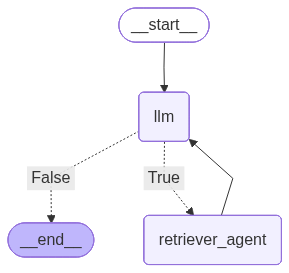

In [13]:
# Visulaize the graph
from IPython.display import Image, display
display(Image(rag_agent.get_graph().draw_mermaid_png()))

In [14]:
def running_agent():
    print("\n=== RAG AGENT===")
    
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break
            
        messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type

        result = rag_agent.invoke({"messages": messages})
        
        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)


In [ ]:
while 1:
    running_agent()


=== RAG AGENT===
Calling Tool: retriever_tool with query: name
Result length: 3818
Tools Execution Complete. Back to the model!
Calling Tool: retriever_tool with query: John
Result length: 3788
Tools Execution Complete. Back to the model!
Calling Tool: retriever_tool with query: Resume
Result length: 4592
Tools Execution Complete. Back to the model!
Calling Tool: retriever_tool with query: Ahmed
Result length: 4571
Tools Execution Complete. Back to the model!
Calling Tool: retriever_tool with query: Curriculum Vitae
Result length: 4494
Tools Execution Complete. Back to the model!
Calling Tool: retriever_tool with query: Mohamed
Result length: 4576
Tools Execution Complete. Back to the model!
Calling Tool: retriever_tool with query: Yousef
Result length: 3776
Tools Execution Complete. Back to the model!

=== ANSWER ===
Your name is **Youssef Omar**【5†L1-L4】.
Calling Tool: retriever_tool with query: university attended GPA
Result length: 4571
Tools Execution Complete. Back to the model!